In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu')
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

um = 1
nm = 0.001
λ  = 1*um


In [2]:
from funciones import GS_phase_retrieval,get_modes_power_scalar

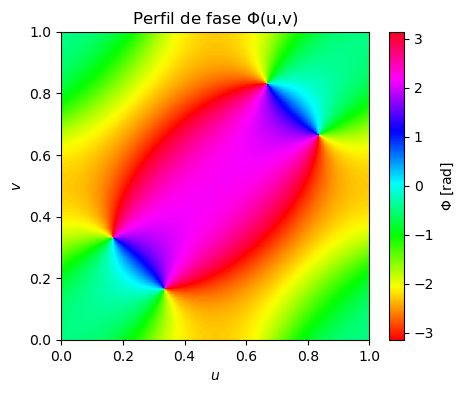

In [3]:
Nx,Ny = 512,512
a = 4
a1 = np.array([a*np.cos(30/180*np.pi), a*np.sin(30/180*np.pi)]) 
a2 = np.array([a*np.cos(30/180*np.pi), -a*np.sin(30/180*np.pi)])
J = jnp.abs(a1[0]*a2[1] - a1[1]*a2[0])
Λx = 2*a*np.cos(30/180*np.pi)
Λy = 2*a*np.sin(30/180*np.pi)
Λu, Λv = 1,1
dx,dy = Λx/Nx , Λy/Ny
du,dv = Λu/Nx , Λv/Ny

incident_power = 0.5 * J
target_power = 0.5 * 7 * J


def input_fun(x,y):
    return x*0 + 1.0


def target_fun(fx,fy):
    nn_, mm_ = fx* Λu, fy* Λv
    target_Cnm = jnp.zeros((Ny,Nx), dtype = 'complex64')
    target_Cnm = target_Cnm.at[(jnp.abs(nn_) < 2)  & (jnp.abs(mm_) < 2)].set(1)
    target_Cnm = target_Cnm.at[Ny//2 - 1, Nx//2 + 1].set(0. + 0.j)
    target_Cnm = target_Cnm.at[Ny//2 + 1, Nx//2 - 1].set(0. + 0.j)
    target_Cnm = target_Cnm.at[Ny//2 + 1, Nx//2 - 1].set(0. + 0.j)
    target_Cnm = target_Cnm.at[Ny//2 - 1, Nx//2 + 1].set(0. + 0.j)
    return target_Cnm /(target_power) * (incident_power)

retrieved_phase,error_list = GS_phase_retrieval(input_fun,target_fun, Λu, Λv, Nx, Ny,num_iter = 200)


fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1,1,1)
im = ax.imshow(retrieved_phase.reshape(Ny,Nx), cmap ='hsv', interpolation  = 'none', extent=[-0, Λu, -0, Λv], vmax = np.pi, vmin = -np.pi)
cb1 = fig.colorbar(im, orientation = 'vertical',fraction=0.045, label = '$\Phi$ [rad]')
ax.set_ylabel("$v$")
ax.set_xlabel('$u$')
ax.set_title(r"Perfil de fase $\Phi$(u,v)")
plt.show()

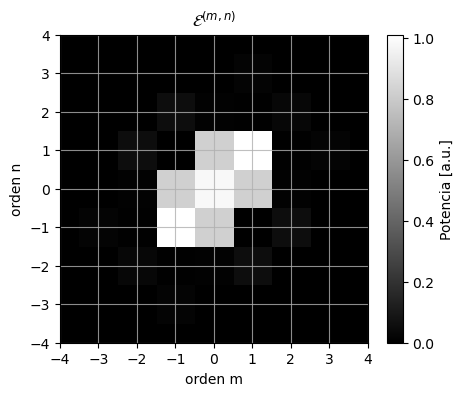

In [4]:
λ = 1*um
mm_, nn_, pow_mode = get_modes_power_scalar(jnp.exp(1j*retrieved_phase), λ, a1 = a1, a2 = a2, 
                           eps = 1,mu = 1)



fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1,1,1)
Nx_ = mm_[0,:]
Ny_ = nn_[:,0]
im = ax.imshow((jnp.abs(pow_mode)), origin = 'lower', cmap ='gray', interpolation  = 'none', extent=[Nx_[0]-0.5, Nx_[-1] +0.5, Ny_[0] -0.5, Ny_[-1] + 0.5],  vmin = 0)
ax.set_title(r"$\mathcal{E}^{\left(m,n\right)}$")
ax.set_xlabel("orden m")
ax.set_ylabel("orden n")
ax.set_xlim([-4,4])
ax.set_ylim([-4,4])

ticks = np.arange(-4, 5, 1)  # Creates an array from -4 to 4 inclusive with a step of 1.
ax.set_xticks(ticks)
ax.set_yticks(ticks)

plt.grid(alpha = 0.8)
cb1 = fig.colorbar(im, orientation = 'vertical')
cb1.set_label('Potencia [a.u.]')
plt.show()

In [5]:
target_Cnm = jnp.zeros((Ny,Nx), dtype = 'bool')
target_Cnm = target_Cnm.at[(jnp.abs(nn_) < 2)  & (jnp.abs(mm_) < 2)].set(True)
target_Cnm = target_Cnm.at[Ny//2 - 1, Nx//2 + 1].set(False)
target_Cnm = target_Cnm.at[Ny//2 + 1, Nx//2 - 1].set(False)
target_Cnm = target_Cnm.at[Ny//2 + 1, Nx//2 - 1].set(False)
target_Cnm = target_Cnm.at[Ny//2 - 1, Nx//2 + 1].set(False)

orders = pow_mode[target_Cnm]
non_uniform = jnp.abs((orders.max()- orders.min())/(orders.max()+ orders.min()))
non_uniform

Array(0.10268256, dtype=float64)

In [6]:
eff = jnp.abs(jnp.sum(orders) /jnp.sum(pow_mode))
eff

Array(0.93547737, dtype=float64)

In [7]:
np.save('grating_phase_triangle-GS_uv.npy', retrieved_phase)

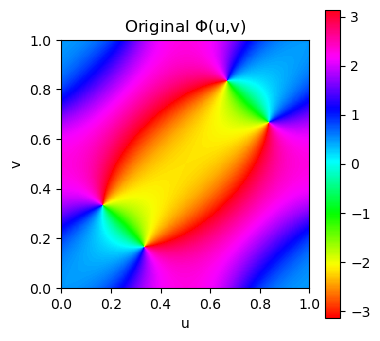

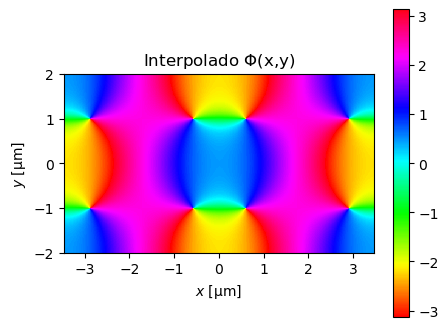

In [8]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt

def interpolate_uv_to_xy(f_uv, u, v, a, x_range, y_range, xy_resolution=100):
    """
    Interpolates a 2D function sampled on a (u,v) grid onto a grid in (x,y) coordinates,
    accounting for periodicity of f(u,v).
    
    The transformation is given by:
    
        u = (sqrt(3)*x)/(3a) + y/a
        v = (sqrt(3)*x)/(3a) - y/a
        
    For points where (u,v) falls outside the base period, the coordinates are wrapped 
    back into the interval defined by the provided u and v arrays.
    
    Parameters:
    -----------
    f_uv : 2D numpy array
        Function values sampled on the (u,v) grid.
        Expected shape is (len(v), len(u)); i.e. first axis corresponds to v.
    u : 1D numpy array
        Array of u coordinates corresponding to the second axis of f_uv.
    v : 1D numpy array
        Array of v coordinates corresponding to the first axis of f_uv.
    a : float
        Parameter used in the transformation.
    x_range : tuple (x_min, x_max)
        Range of x values for the (x,y) grid.
    y_range : tuple (y_min, y_max)
        Range of y values for the (x,y) grid.
    xy_resolution : int, optional
        Number of grid points along each axis for the (x,y) grid (default is 100).
    
    Returns:
    --------
    X, Y : 2D numpy arrays
        Meshgrid arrays for the x and y coordinates.
    f_xy : 2D numpy array
        Interpolated function values on the (x,y) grid.
    """
    # Create the interpolator for the periodic function f_uv.
    # The first axis corresponds to v and the second to u.
    interpolator = RegularGridInterpolator((v, u), f_uv, bounds_error=False, fill_value=None)
    
    # Create the (x,y) grid.
    x = np.linspace(x_range[0], x_range[1], xy_resolution)
    y = np.linspace(y_range[0], y_range[1], xy_resolution)
    X, Y = np.meshgrid(x, y)
    
    # Compute the corresponding (u,v) coordinates using the forward transformation.
    u_coord = (np.sqrt(3) * X) / (3 * a) + Y / a
    v_coord = (np.sqrt(3) * X) / (3 * a) - Y / a
    
    # For periodicity: wrap (u,v) back to the base period.
    # Here we assume that the sampled u and v define one period.
    # Determine period lengths.
    # (If u and v are defined using np.linspace(0,1,uv_resolution, endpoint=False), then period is 1.)
    u_min, u_max = u[0], u[-1] + (u[1]-u[0])
    v_min, v_max = v[0], v[-1] + (v[1]-v[0])
    period_u = u_max - u_min
    period_v = v_max - v_min
    
    u_coord_mod = u_min + np.mod(u_coord - u_min, period_u)
    v_coord_mod = v_min + np.mod(v_coord - v_min, period_v)
    
    # Prepare the points for interpolation. Note the order: (v, u)
    points = np.array([v_coord_mod.ravel(), u_coord_mod.ravel()]).T
    f_xy = interpolator(points).reshape(X.shape)
    
    return X, Y, f_xy


# ----------------------------
# Example usage of the function
# ----------------------------
# Parameter a.
a = 4.0
Λx = 2*a*np.cos(30/180*np.pi)
Λy = 2*a*np.sin(30/180*np.pi)

# Create a (u,v) grid on which f_uv is sampled.
uv_resolution = 512
u = np.linspace(0, 1, uv_resolution)
v = np.linspace(0, 1, uv_resolution)
U, V = np.meshgrid(u, v)



# Define the desired (x,y) grid range.
x_range = (-Λx/2, Λx/2)  # example range for x
y_range = (-Λy/2, Λy/2)              # example range for y

# Interpolate the function from (u,v) space to (x,y) space.
X, Y, retrieved_phase_xy = interpolate_uv_to_xy(np.array(-retrieved_phase), u, v, a, x_range, y_range, xy_resolution=512)

# Plot the original f(u,v) and the interpolated f(x,y).
plt.figure(figsize=(4, 4))

# Plot the original function in (u,v) space.
plt.subplot(1, 1, 1)
plt.imshow(-retrieved_phase, extent=[u[0], u[-1], v[0], v[-1]],  aspect='equal', cmap = 'hsv', interpolation = 'none')
plt.title("Original $\Phi$(u,v)")
plt.xlabel("u")
plt.ylabel("v")
plt.colorbar()
plt.figure(figsize=(5, 4))

# Plot the interpolated function in (x,y) space.
plt.subplot(1, 1, 1)
plt.imshow(retrieved_phase_xy, extent=[x_range[0], x_range[1], y_range[0], y_range[1]],  aspect='equal', cmap = 'hsv', interpolation = 'none')
plt.title("Interpolado $\Phi$(x,y)")
plt.xlabel("$x$ [μm]")
plt.ylabel('$y$ [μm]')
plt.colorbar()

plt.show()


In [9]:
np.save('grating_phase_triangle-GS_xy.npy', retrieved_phase_xy)

In [10]:
from scipy.interpolate import interpn

phase = np.load('grating_phase_triangle-GS_xy.npy')

a=4
Λx = 2*a*np.cos(30/180*np.pi)
Λy = 2*a*np.sin(30/180*np.pi)
Ny_old,Nx_old = phase.shape
x_old = jnp.linspace(0, Λx, Nx_old)
y_old = jnp.linspace(0, Λy, Ny_old)
Ny, Nx = 6326 //3,6326 //3
extent_x = 200
extent_y = 200
dx = extent_x/Nx
dy = extent_y/Ny
x = dx * (jnp.arange(Nx)-Nx//2)
y = dy * (jnp.arange(Ny)-Ny//2)
xx, yy = jnp.meshgrid(x, y)
oldpoints = (x_old,y_old)
newpoints = np.vstack([(xx%Λx).ravel(),(yy%Λy).ravel()]).T
phase_grating_interpolated = jnp.arctan2( interpn(oldpoints, np.sin(phase).T, newpoints, bounds_error=True, fill_value = 0, method = 'linear').reshape((Ny, Nx))   ,   interpn(oldpoints, np.cos(phase).T, newpoints, bounds_error=True, fill_value = None, method = 'linear').reshape((Ny, Nx))  )


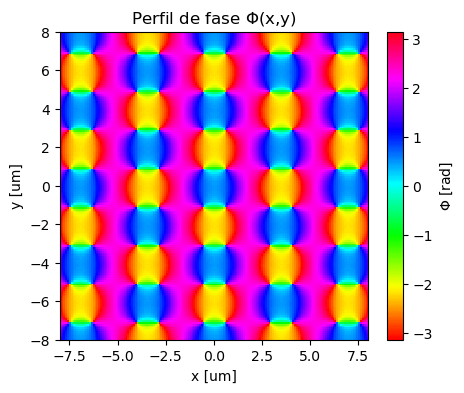

In [12]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1,1,1)

im = ax.imshow(phase_grating_interpolated, cmap ='hsv', interpolation  = 'none', extent = [xx[0,0], xx[0,-1],yy[0,0], yy[-1,0]], vmax = np.pi, vmin = -np.pi)
cb1 = fig.colorbar(im, orientation = 'vertical',fraction=0.045, label = '$\Phi$ [rad]')

ax.set_title(r"Perfil de fase $\Phi$(x,y)")
ax.set_ylabel("y [um]")
ax.set_xlabel("x [um]")
ax.set_xlim([-8,8])
ax.set_ylim([-8,8])

plt.show()


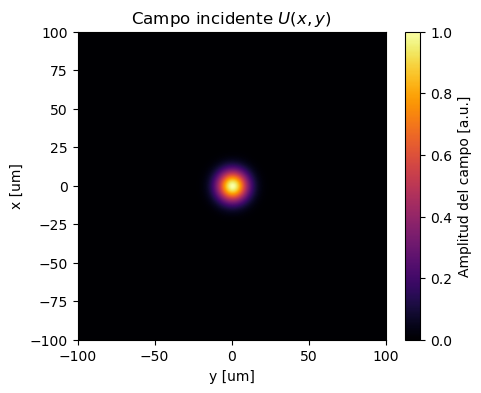

78.53981633974483

In [35]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1,1,1)

U_new = jnp.exp(-((xx**2 +  yy**2) / 10**2)) * jnp.exp(1j*phase_grating_interpolated)

im = ax.imshow(np.abs(U_new), cmap ='inferno', extent=[float(x[0]), float(x[-1])+dx, float(y[0]), float(y[-1])+dy])
ax.set_title("Campo incidente $U(x,y)$")
ax.set_ylabel("x [um]")
ax.set_xlabel('y [um]')


lim = np.array([-5,5])
#ax.set_xlim(lim)
#ax.set_ylim(lim)

cb1 = fig.colorbar(im, orientation = 'vertical')
cb1.set_label('Amplitud del campo [a.u.]')
plt.show()


from scipy.integrate import simps
Iz = 0.5*np.real(np.multiply(U_new,np.conj(U_new)))
power00 = simps(simps(Iz, x), y)
power00

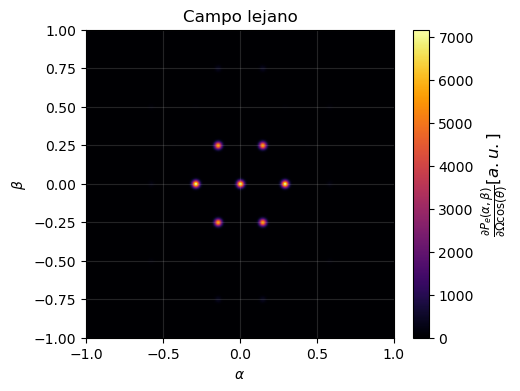

In [37]:
from funciones import get_farfield_radiant_intensity_percos_scalar

λ= 1.0
α, β, Intensity = get_farfield_radiant_intensity_percos_scalar(x, y, U_new, λ)


fig = plt.figure(figsize=(5,4)) 
ax = fig.add_subplot(1,1,1)  
ax.grid(alpha =0.2)
ax.set_title(r"Campo lejano")
ax.set_ylabel("$β$")
ax.set_xlabel('$α$')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

im = ax.imshow((Intensity), extent = [α[0],α[-1],β[0],β[-1]], origin = 'lower', cmap = 'inferno',vmax =  (Intensity.max()))
cb1 = fig.colorbar(im, orientation = 'vertical')
cb1.set_label(r"$\frac{\partial P_e(α,β)}{\partial \Omega \cos(\theta)} [a.u.]$", size= 12)
plt.show()
